In [1]:
import pandas as pd
import tensorflow as tf

DATA_PATH = '/home/kshipra/work/major/ml experiments/data/manually_combined.xlsx'

eos = pd.read_excel(DATA_PATH, sheet_name='all_stacked_eos')
sentinel = pd.read_excel(DATA_PATH, sheet_name='all_stacked_sentinel')
combined = pd.read_excel(DATA_PATH, sheet_name='eos_sent_combined')

len(eos), len(sentinel), len(combined)

2025-09-23 21:09:09.298669: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(747, 796, 747)

In [2]:
X_cols = ['VH', 'VV', 'HH', 'HV', 'Angle']
y_col = ['SM (Combined)']

num_features = len(X_cols)

In [3]:
combined = combined[combined['SM (Combined)'] < 150]

combined

,VH,VV,Angle,SM (Sent),HH,HV,SM (EOS),SM (Combined),Unnamed: 8,Latitude (S),Longitude (S),Latitude (E),Longitude (E),Lat Diff,Long Diff,SM Diff
0,-14.947200,-10.379400,40.366800,20.6,-7.38713,-15.09099,24.4,22.50,NaN,22.526048,72.765011,22.526048,72.765011,0.000000,0.000000,-3.8
1,-16.361200,-11.299400,41.008800,25.8,-6.25740,-12.05392,41.0,33.40,NaN,22.525481,72.765028,22.525481,72.765028,0.000000,0.000000,-15.2
2,-16.168800,-10.992000,42.359800,28.9,-8.44134,-16.46069,25.3,27.10,NaN,22.525423,72.765663,22.525423,72.765663,0.000000,0.000000,3.6
3,-15.630700,-8.829090,42.982700,4.1,-2.85467,-17.00499,53.7,28.90,NaN,22.525999,72.765663,22.525999,72.765663,0.000000,0.000000,-49.6
4,-15.130900,-10.333000,41.434700,35.3,-6.88868,-12.32378,53.4,44.35,NaN,22.525563,72.765399,22.525563,72.765399,0.000000,0.000000,-18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742,-15.603123,-10.557852,42.709682,30.2,-8.69274,-14.15688,26.8,28.50,NaN,22.505581,72.764064,22.523640,72.766727,-0.018059,-0.002663,3.4
743,-16.321512,-11.300431,42.176147,38.3,-6.48271,-15.56076,32.8,35.55,NaN,22.505961,72.764083,22.523657,72.766016,-0.017696,-0.001933,5.5
744,-15.585269,-11.489754,42.523727,20.0,-6.20660,-14.73141,34.8,27.40,NaN,22.506133,72.763434,22.524255,72.766024,-0.018122,-0.002590,-14.8
745,-16.052544,-10.954885,42.562408,39.7,-9.43414,-20.52987,27.8,33.75,NaN,22.505784,72.763859,22.524229,72.766601,-0.018445,-0.002742,11.9


In [4]:
def model_to_string(model, arrow=' -> '):
    import tensorflow as tf

    def _repr_layer(layer):
        cls = layer.__class__.__name__

        # Skip input layers
        if isinstance(layer, tf.keras.layers.InputLayer):
            return None

        # Dense: show units and non-linear activation
        if cls == 'Dense':
            units = getattr(layer, 'units', None)
            act = getattr(layer, 'activation', None)
            act_name = None
            if act is not None and hasattr(act, '__name__'):
                act_name = act.__name__
            # append activation if it's not linear
            return f"{units}" + (f"({act_name})" if act_name and act_name != 'linear' else "")

        # Dropout: show rate
        if cls == 'Dropout':
            rate = getattr(layer, 'rate', None)
            return f"Dropout({rate})"

        # Activation layer (separate layer)
        if cls == 'Activation':
            act = getattr(layer, 'activation', None)
            act_name = act.__name__ if (act is not None and hasattr(act, '__name__')) else str(act)
            return f"Activation({act_name})"

        # Nested model: recurse and wrap in parentheses
        if hasattr(layer, 'layers') and isinstance(layer.layers, (list, tuple)):
            inner = model_to_string(layer, arrow)
            return f"({inner})" if inner else None

        # Generic fallback: use class name (keeps it informative)
        return cls

    parts = []
    for layer in getattr(model, 'layers', []):
        s = _repr_layer(layer)
        if s:
            parts.append(s)
    return arrow.join(parts)


## Finetuning value of `r`

In [5]:
all_results = dict()

In [6]:
from model_experiments import PredictionIntervalWithTubeLoss
from tensorflow import keras
model = keras.Sequential([
    keras.Input(shape=(len(X_cols), )),
    keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    keras.layers.Dense(4, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

r_vals = [0.1, 0.3, 0.5, 0.7, 0.9]
r_results = dict()

for r in r_vals:
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.02,
        decay_steps=10000,
        decay_rate=0.01)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    param_string = model_to_string(model)

    pi = PredictionIntervalWithTubeLoss(combined, X_cols, y_col[0], satellite='EOS+Sentinel', r=r)

    results = pi.run_experiment(model=model, optimizer=opt, epochs=500, 
                                model_param_string=param_string, plot_losses=False, plot_interval=False,
                                return_preds=True)
    
    r_results[r] = results

Epochs:   5%|▍         | 24/500 [00:02<00:53,  8.97epoch/s, loss=0.7755, val_loss=0.7481] 


In [7]:
import pandas as pd

df = pd.DataFrame([
    {
        "r": r,
        "test_PICP": vals["test_results"]["PICP"],
        "test_MPIW": vals["test_results"]["MPIW"],
        "val_PICP": vals["val_results"]["PICP"],
        "val_MPIW": vals["val_results"]["MPIW"],
    }
    for r, vals in r_results.items()
])

df

,r,test_PICP,test_MPIW,val_PICP,val_MPIW
0,0.1,0.893333,43.539001,0.946429,43.606998
1,0.3,0.960000,32.938999,0.952381,33.367001
2,0.5,0.960000,34.879002,0.946429,35.209000
3,0.7,0.960000,61.237999,0.952381,62.094002
4,0.9,0.946667,40.025002,0.952381,40.539001


## Finetuning value of `delta`

In [14]:
from model_experiments import PredictionIntervalWithTubeLoss
from tensorflow import keras
model = keras.Sequential([
    keras.Input(shape=(len(X_cols), )),
    keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    keras.layers.Dense(4, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])


delta_vals = [0, 0.01, 0.05, 0.1, 0.2]
delta_results = dict()

for delta in delta_vals:
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.02,
        decay_steps=10000,
        decay_rate=0.01)
    opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    param_string = model_to_string(model)

    pi = PredictionIntervalWithTubeLoss(combined, X_cols, y_col[0], satellite='EOS+Sentinel', r=0.5, delta=delta)

    results = pi.run_experiment(model=model, optimizer=opt, epochs=500, 
                                model_param_string=param_string, plot_losses=False, plot_interval=False,
                                return_preds=True)
    
    delta_results[delta] = results

Epochs:  66%|██████▌   | 331/500 [00:27<00:14, 12.06epoch/s, loss=4.2603, val_loss=4.3044]


In [15]:
import pandas as pd

df = pd.DataFrame([
    {
        "delta": delta,
        "test_PICP": vals["test_results"]["PICP"],
        "test_MPIW": vals["test_results"]["MPIW"],
        "val_PICP": vals["val_results"]["PICP"],
        "val_MPIW": vals["val_results"]["MPIW"],
    }
    for delta, vals in delta_results.items()
])

df

,delta,test_PICP,test_MPIW,val_PICP,val_MPIW
0,0.00,0.746667,24.628000,0.797619,24.628000
1,0.01,0.960000,31.969999,0.940476,32.330002
2,0.05,0.800000,21.599001,0.851190,21.659000
3,0.10,0.613333,14.655000,0.636905,14.655000
4,0.20,0.493333,11.359000,0.553571,11.504000


In [5]:
from model_experiments import PredictionIntervalWithTubeLoss
from tensorflow import keras

tf.keras.backend.clear_session()

model1 = tf.keras.Sequential([
    # Input layer
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(16, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dropout(0.09),
    tf.keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

model2 = tf.keras.Sequential([
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(8, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

model3 = tf.keras.Sequential([
    tf.keras.Input(shape=(len(X_cols), )),
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)),
    tf.keras.layers.Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3),
                bias_initializer=keras.initializers.Constant(value=[-3,3]))
])

## Exp 1

Epochs:  90%|█████████ | 18/20 [00:02<00:00,  6.45epoch/s, loss=0.6346, val_loss=0.6572] 


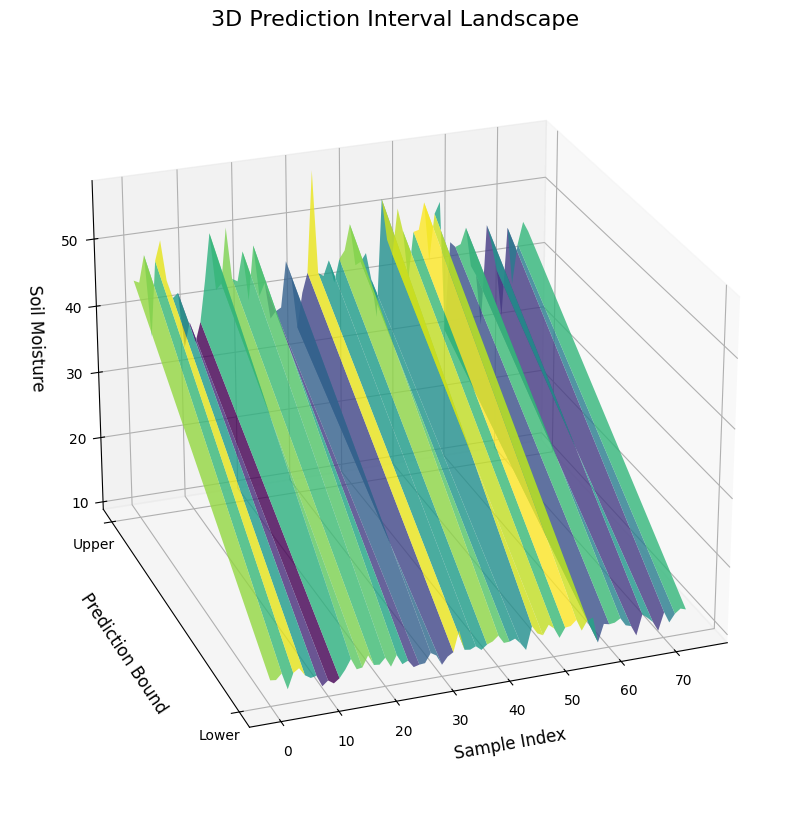

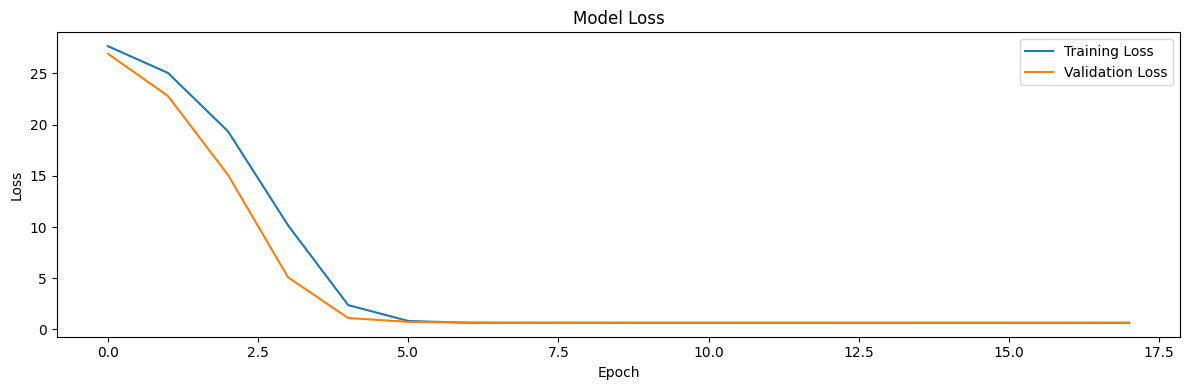

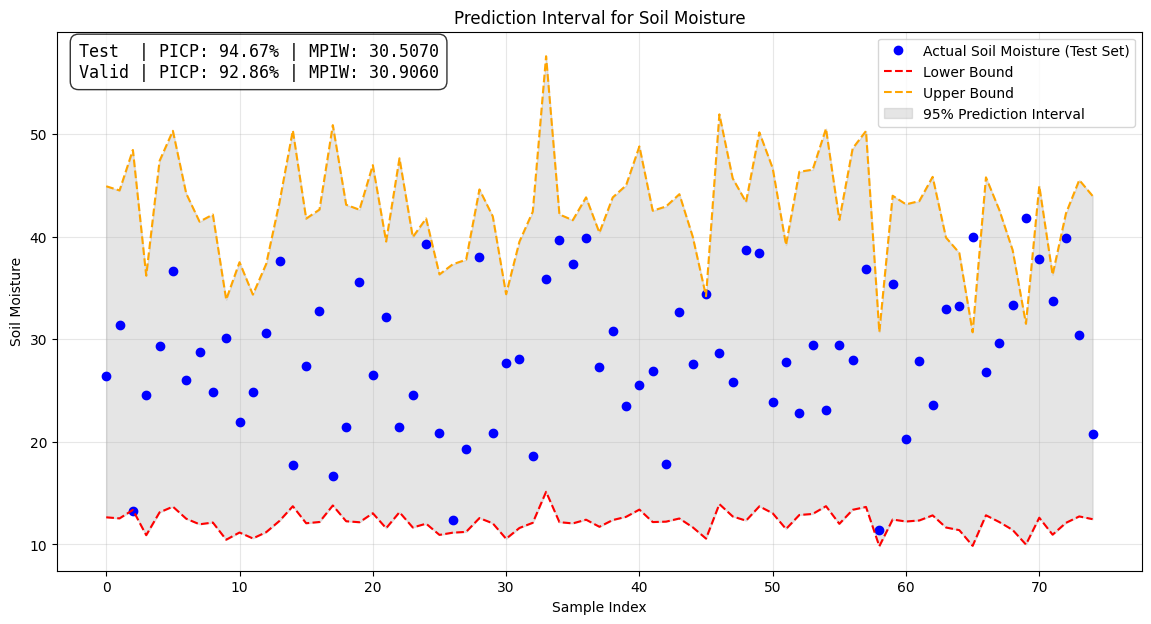

In [6]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

pi = PredictionIntervalWithTubeLoss(combined, features=X_cols, target=y_col[0])
pi.train_model(model3, optimizer=opt, num_epochs=20)
pi.plot_prediction_interval_3d()
pi.plot_losses()
pi.plot_prediction_interval()

## Exp 2

Epochs:  37%|███▋      | 367/1000 [00:29<00:50, 12.56epoch/s, loss=0.6311, val_loss=0.6586] 
/home/kshipra/work/major/ml experiments/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


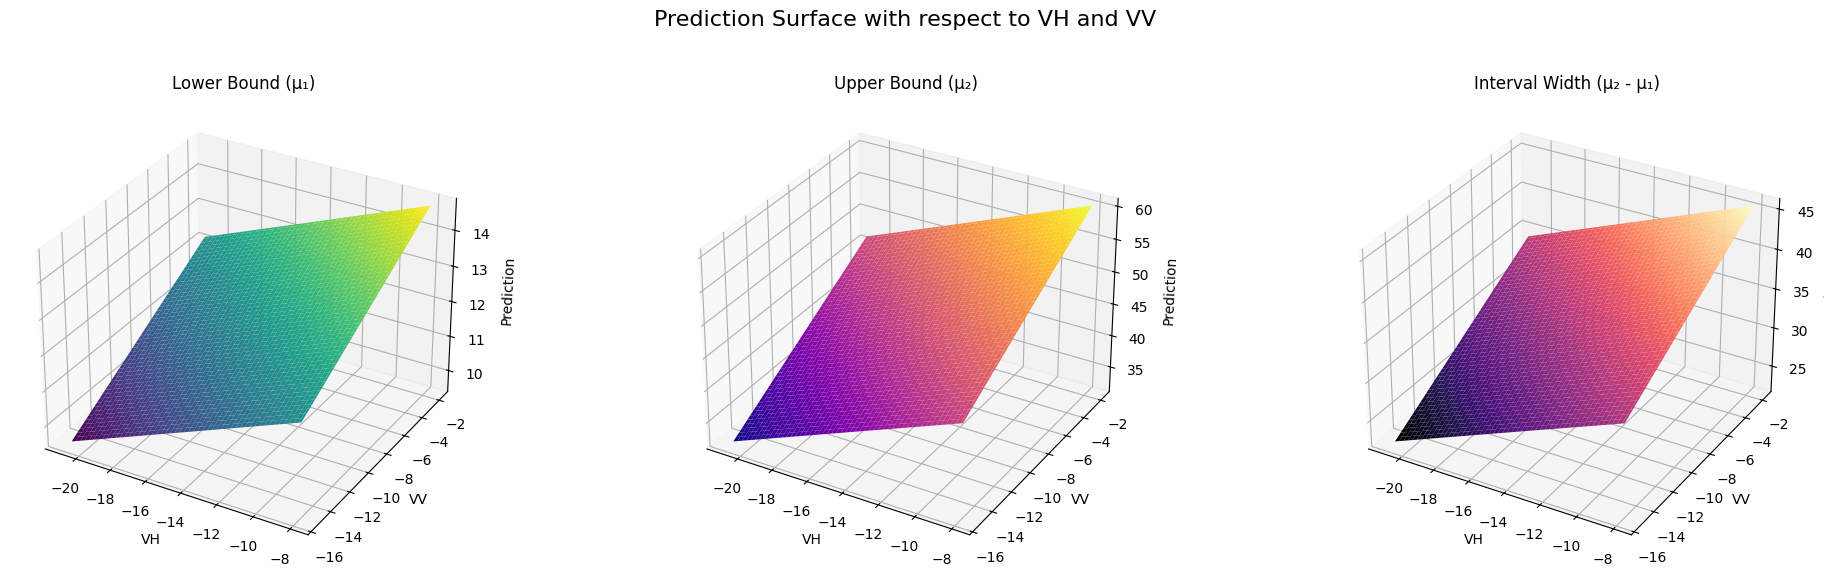

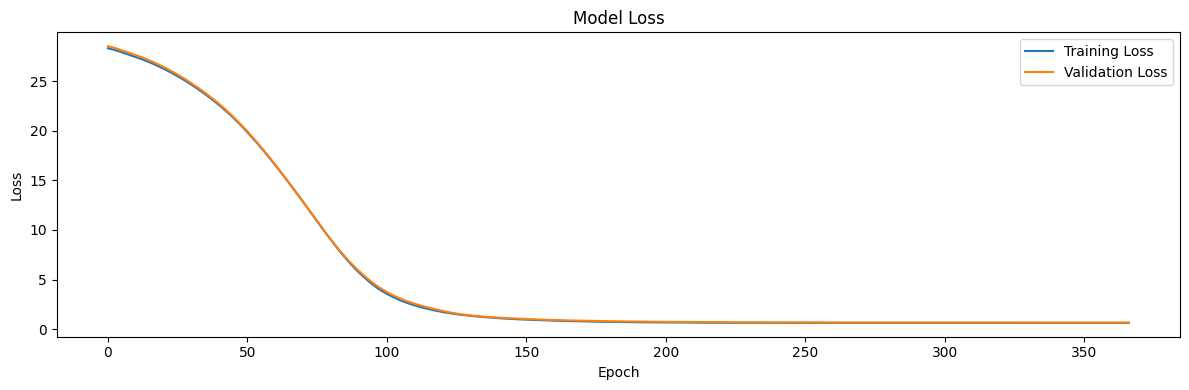

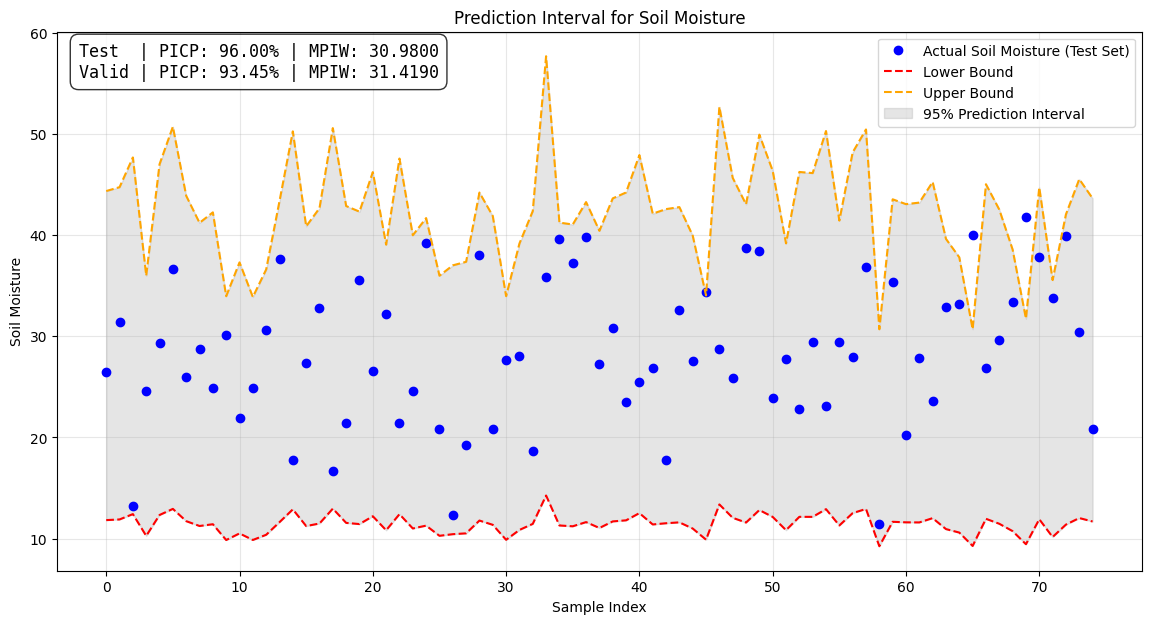

In [12]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

pi= PredictionIntervalWithTubeLoss(combined, features=X_cols, target=y_col[0])
pi.train_model(model2, optimizer=opt, num_epochs=1000)
pi.plot_prediction_surface('VH', 'VV', 100)
pi.plot_losses()
pi.plot_prediction_interval()

## Exp 3

Epochs:  13%|█▎        | 13/100 [00:02<00:17,  4.89epoch/s, loss=0.8293, val_loss=0.7460] 


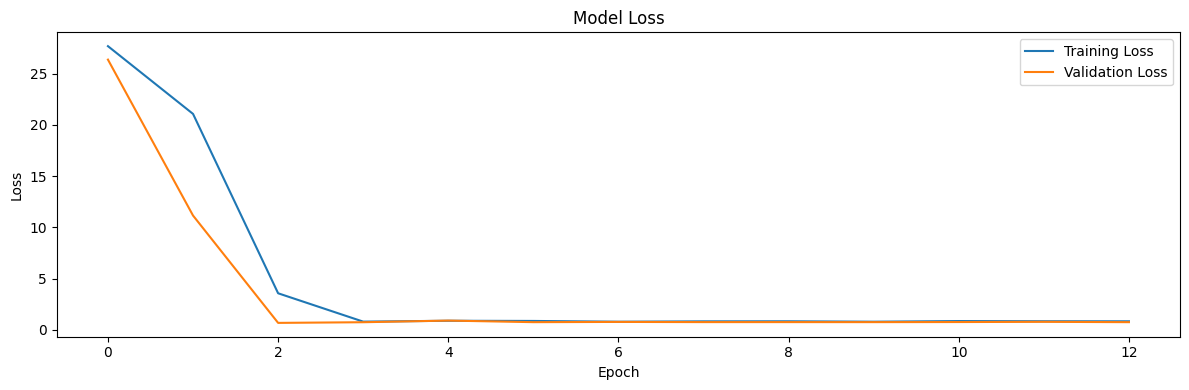

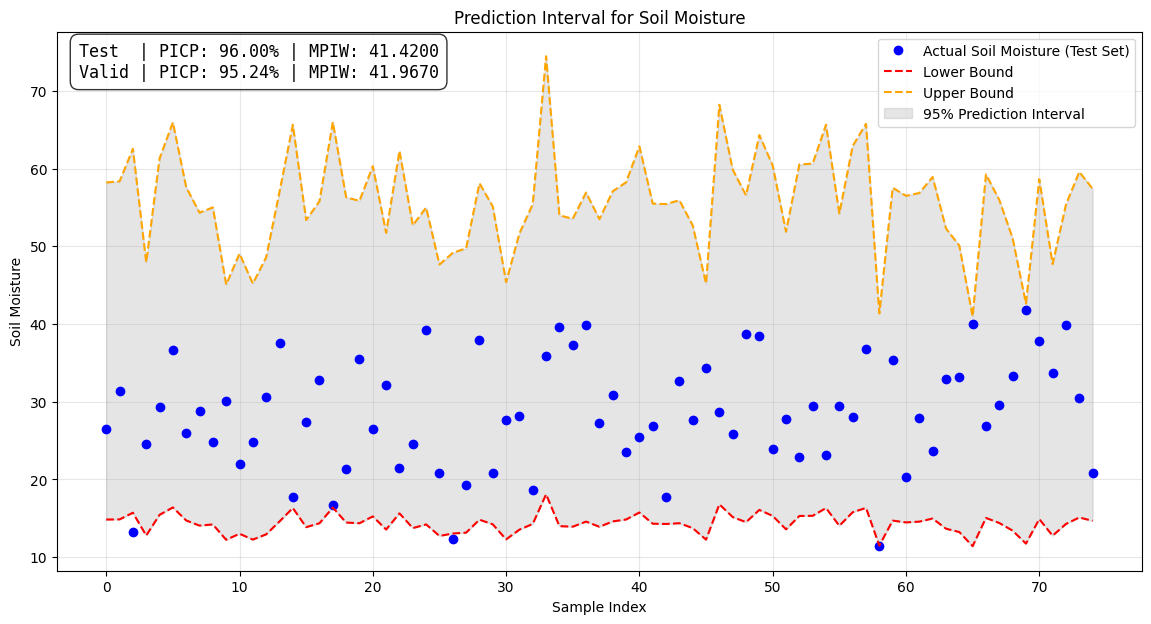

In [7]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=10000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

pi= PredictionIntervalWithTubeLoss(combined, features=X_cols, target=y_col[0])
pi.train_model(model1, optimizer=opt)
pi.plot_losses()
pi.plot_prediction_interval()